Vedant Singh Rathore
<br>Hackathon

## Importing necessary libraries and data

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For Data Treatment
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score, make_scorer
from sklearn import tree

# For tuning the model
from sklearn.model_selection import GridSearchCV
import datetime

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/vedantrathore/VSCode Working Folder/mit_idss/shinka_travel_exp_hackathon/')

In [340]:
train_data_path = os.getcwd()+'/data/train/'
test_data_path = os.getcwd()+'/data/test/'

survey_train = pd.read_csv(train_data_path+'Surveydata_train.csv')
travel_train = pd.read_csv(train_data_path+'Traveldata_train.csv')

survey_test = pd.read_csv(test_data_path+'Surveydata_test.csv')
travel_test = pd.read_csv(test_data_path+'Traveldata_test.csv')

In [341]:
train_df = pd.merge(travel_train, survey_train, on='ID', how='left')
df = train_df.copy()

test_df = pd.merge(travel_test, survey_test, on='ID', how='left')
out_df = test_df.copy()

In [342]:
target_col = 'Overall_Experience'
id_col = 'ID'

## Data Overview

- Observations
- Sanity checks

In [343]:
### First 5 rows
df.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0,0,...,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0,0,...,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0,1,...,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0,0,...,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0,1,...,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [344]:
#### Print Rows and Columns
print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')

Rows: 94379
Columns: 25


In [345]:
### Checking info of the data ###
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Platform_Location     

1. No Null Values
2. All Data Types Correct
3. 1 ID column to be dropped before modelling as it doesn't provide any information. **Kept until modelling to keep count of classes**.
4. Target Column: status

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

In [346]:
## Filter Numeric Columns from the dataframe
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()
## Drop target columns
numeric_columns.remove(id_col)

columns = list(df.columns)
columns.remove(id_col)

In [347]:
numeric_columns

['Age',
 'Travel_Distance',
 'Departure_Delay_in_Mins',
 'Arrival_Delay_in_Mins',
 'Overall_Experience']

In [348]:
### Summary of Categorical Columns
## df.describe method can be used to print the statistical summary of the data
## include='object' argument provides the summary for ordinal columns
df.describe(include='object').T

,count,unique,top,freq
Gender,94302,2,Female,47815
Customer_Type,85428,2,Loyal Customer,69823
Type_Travel,85153,2,Business Travel,58617
Travel_Class,94379,2,Eco,49342
Seat_Comfort,94318,6,Acceptable,21158
Seat_Class,94379,2,Green Car,47435
Arrival_Time_Convenient,85449,6,Good,19574
Catering,85638,6,Acceptable,18468
Platform_Location,94349,6,Manageable,24173
Onboard_Wifi_Service,94349,6,Good,22835


In [349]:
### Summary of Numerical Columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Age,94346.0,3.941965e+01,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1.978888e+03,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,1.464709e+01,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,1.500522e+01,38.439409,0.0,0.0,0.0,13.0,1584.0
Overall_Experience,94379.0,5.466576e-01,0.497821,0.0,0.0,1.0,1.0,1.0


**Univariate Analysis**

In [350]:
## Create a univariate analysis function that takes the dataframe, the column to be analyzed and a flag to check if the column is an id column
## This function can be used to analyze all the columns in the data without rewriting any piece of plotting code
def uni_analyze(df,col,id_col=False):
  print("-"*300)
  print(f'\nUnivariate Analysis of {col}\n')
  """Check if the given column is an id column"""
  if id_col==False:
    """If not an id column, check if the column is of 'object' dtype"""
    if df[col].dtype=='object':
      """Print the value counts for the column"""
      print(f'Unique Set of Values for {col}:\n{df[col].value_counts()}\n')
      plt.figure(figsize = (15,5))
      """If the number of unique entries in the column is less than 20, Plot the countplot"""
      """Too many unique values will lead to crowding of the plot"""
      if df[col].nunique()<20:
        fig = sns.countplot(data = df, x = col)
        for patch in fig.patches:
          label = patch.get_height()
          x = patch.get_x() + patch.get_width() / 2  # width of the plot
          y = patch.get_height()
          fig.annotate(label,(x,y))
      else:
        print('\nToo many distinct variables to be plotted on a countplot!!')
      plt.show()

    else:
      """If not an 'object' column, i.e. for numeric columns"""
      """Print the Mean, Median, Min, Max and Skew of the column"""
      print(f'Stats for the column {col}:\n Mean: {df[col].mean()}\n Min: {df[col].min()}\n Max: {df[col].max()}\n Median: {df[col].median()}\n Skew: {df[col].skew()}\n')

      f, (hist_plot, box_plot) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.75, 0.25)},
        figsize=(15,5)
      )
      """Subplot Histogram of the column"""
      sns.histplot(data=df,x=col, ax=hist_plot, kde=False) ## Histogram
      """Plot the boxplot of the column"""
      sns.boxplot(data=df,x=col, ax=box_plot) ## Boxplot
      """Add Mean to histogram"""
      hist_plot.axvline(df[col].mean())
      """Add Median to histplot"""
      hist_plot.axvline(df[col].mean())
      f.suptitle(f'Boxplot & Histogram for {col}')
      plt.show()

  else:
    """If an ID column, show the total number of unique counts in the column and print sample data"""
    print(f'Unique Values for {col}:\n{df[col].nunique()}')
    print(f'\n Sample data\n')
    print(df[col].head())

In [351]:
# ## To Analyze All Columns in a single output block
# ## Creating an analyze function helps iterate over the df.columns list and print all outputs in one output block
# for column in categorical_columns:
#   uni_analyze(df,column)

In [352]:
# ## To Analyze All Columns in a single output block
# ## Creating an analyze function helps iterate over the df.columns list and print all outputs in one output block
# for column in numeric_columns:
#   uni_analyze(df,column)

**Multivariate Analysis**

In [353]:
## Barplots and distplots are some of the best plots for multivariate analysis
### Distribution Plot
def distribution_plot(data, predictor, target):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    target_uniq = data[target].unique()

    axs[0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0],
        color="teal",
        stat="density",
    )

    axs[1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[1],
        color="orange",
        stat="density",
    )

    plt.show()
### Bar Plot
def bar_plot(df,feature, target):
    plt.figure(figsize=(15,7))
    ## Get feature wise percentage split of converting and non-converting
    plot_df = pd.crosstab(df[feature], df[target]).sort_values(by=df[target].value_counts().index[-1], ascending=False)
    plot_df.plot(kind="bar", stacked=True)
    plt.xticks(rotation = 60)
    plt.show()

## Create a dataframe to observe the conversion rate basis given column
def check_conversion_split(df,col,target):
  temp_df = df.groupby([col,target]).agg({'ID':'count'}).reset_index()
  temp_df = temp_df.pivot(index=col, columns=target, values='ID').reset_index()
  temp_df['conversion_rate'] = temp_df[1]*100/(temp_df[0]+temp_df[1])
  return temp_df

## This functions take the dataframe and the feature & target columns as input and outputs the stacked barplot and distribution plots
## Rather than rewriting the code for each pair of variables, this function can be reused with different col_list to get desired output
def multi_analyze(df,feature, target):
  bar_plot(df,feature, target)
  print("-"*300)
  distribution_plot(data=df,predictor=feature,target=target)
  check_conversion_split(df,feature,target)

**Correlation Matrix**

In [354]:
# ## Plot Correlation Matrix
# corr_columns = df.select_dtypes(include=np.number).columns.tolist()

# plt.figure(figsize=(12, 7))
# sns.heatmap(
#     df[corr_columns].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
# plt.show()

In [355]:
# for col in categorical_columns:
#     multi_analyze(df, col, target_col)

## Data Preprocessing

- Missing value treatment (if needed): **No missing value**
- Feature engineering (if needed): **Carried out below**
- Outlier detection and treatment (if needed): **Carried out below**
- Preparing data for modeling: **Carried out below**

### Treatment and Transformations

In [356]:
def fill_na(data):
    for col in data.columns:
        if col in categorical_columns:
            mode = data[col].mode().values[0]
            data[col].fillna(mode, inplace=True)
        else:
            median = data[col].median()
            data[col].fillna(median, inplace=True)
    
    return data

df = fill_na(df)
out_df = fill_na(test_df)

In [214]:
# df = df.dropna()

**Outlier Treatment**

In [357]:
outlier_columns = numeric_columns
outlier_columns.remove(target_col)

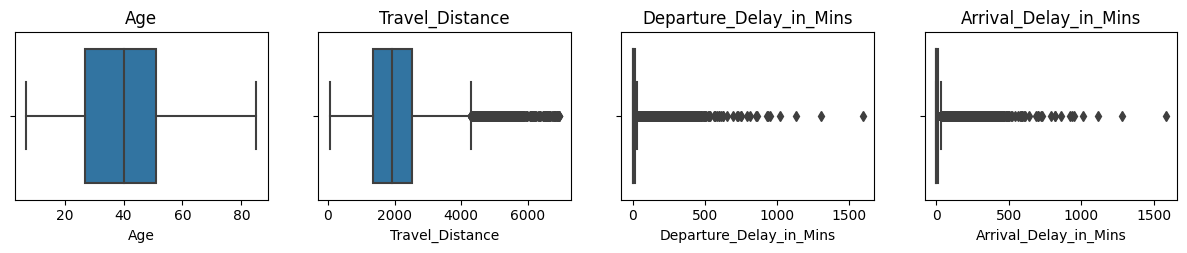

In [358]:
### Check for outliers
plt.figure(figsize=(15, 10))
for col, col_name in enumerate(outlier_columns):
    plt.subplot(4, 4, col + 1)
    sns.boxplot(data=df,x=col_name)
    plt.title(col_name)

plt.show()

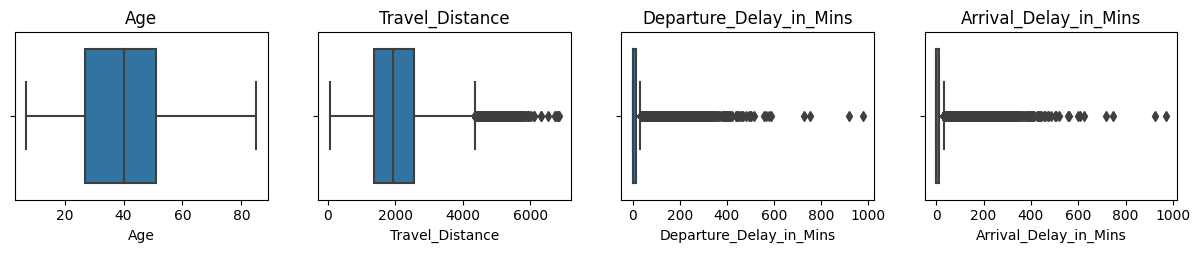

In [359]:
### Check for outliers
plt.figure(figsize=(15, 10))
for col, col_name in enumerate(outlier_columns):
    plt.subplot(4, 4, col + 1)
    sns.boxplot(data=out_df,x=col_name)
    plt.title(col_name)

plt.show()

In [360]:
### Cap extreme values at 5th and 95th percentile

def cap_column_values(df, column_name):
    # Calculate the 5th and 95th percentiles
    lower_bound = df[column_name].quantile(0.05)
    upper_bound = df[column_name].quantile(0.95)

    # Cap the column values between the percentiles
    df[column_name] = df[column_name].clip(lower=lower_bound, upper=upper_bound)
    return df

for col in numeric_columns:
  df = cap_column_values(df,col)
  out_df = cap_column_values(out_df,col)

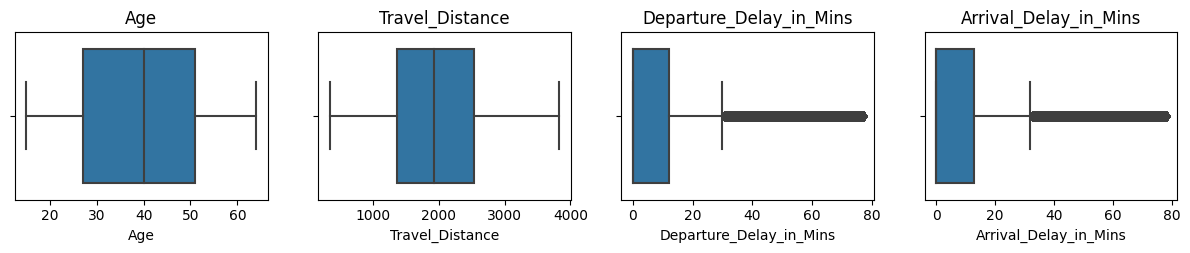

In [361]:
### Check for outliers
plt.figure(figsize=(15, 10))
for col, col_name in enumerate(outlier_columns):
    plt.subplot(4, 4, col + 1)
    sns.boxplot(data=df,x=col_name)
    plt.title(col_name)

plt.show()

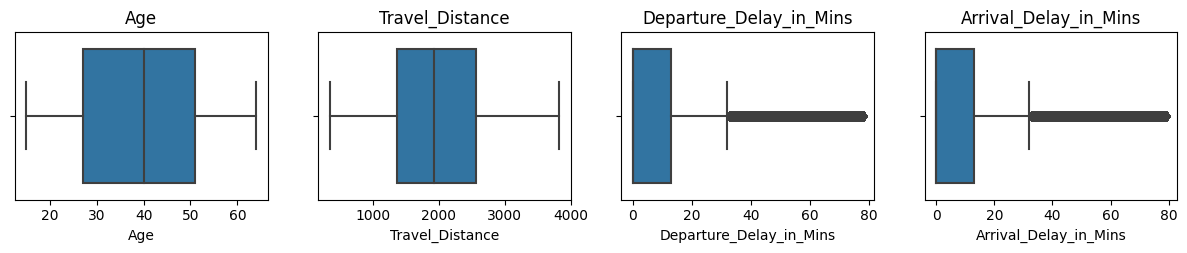

In [362]:
### Check for outliers
plt.figure(figsize=(15, 10))
for col, col_name in enumerate(outlier_columns):
    plt.subplot(4, 4, col + 1)
    sns.boxplot(data=out_df,x=col_name)
    plt.title(col_name)

plt.show()

**Creating dummy variables for categorical Variables**

In [363]:
# Creating dummy variables
df = pd.get_dummies(data = df, columns = categorical_columns, drop_first = True)
out_df = pd.get_dummies(data = out_df, columns = categorical_columns, drop_first = True)

drop_cols = list(set(df.columns)-set(out_df.columns))
drop_cols.remove(target_col)
df = df.drop(columns=drop_cols, axis=0)

**Removing Skewness**

In [364]:
## Check Skewness in the data
for col in numeric_columns:
  print(col, df[col].skew())

Age -0.01362921971385643
Travel_Distance 0.17029342785606932
Departure_Delay_in_Mins 2.093745872830693
Arrival_Delay_in_Mins 2.080307695106285


In [365]:
## Check Skewness in the data
for col in numeric_columns:
  print(col, out_df[col].skew())

Age -0.01528887154456359
Travel_Distance 0.16288095952907958
Departure_Delay_in_Mins 2.0951830365384905
Arrival_Delay_in_Mins 2.0715427824155164


In [224]:
# def remove_skewness(df, column_name):
#     # Apply transformation to the specified column
#     if df[column_name].skew()>=0:
#       df[column_name] = np.sqrt(df[column_name])
#     else:
#       transformed_data, _ = boxcox(df[column_name])
#       df[column_name] = transformed_data

#     return df


# for col in numeric_columns:
#   df = remove_skewness(df,col)

**Define X, Y, Test and Train**

In [366]:
X = df.drop([target_col,id_col], axis=1)
out_df = out_df.drop([id_col], axis=1)
Y = df[target_col]

## Enable Stratified Sampling while performing split using stratify argument
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)

**Scaling the data**

In [367]:
# Scaling the data
sc=StandardScaler()

# Fit_transform on train data
X_train_scaled=sc.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X.columns)

# Transform on test data
X_test_scaled=sc.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X.columns)

out_df_scaled = sc.transform(out_df)
out_df_scaled = pd.DataFrame(out_df_scaled, columns=X.columns)

In [368]:
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set:
Overall_Experience
1    0.546659
0    0.453341
Name: proportion, dtype: float64
Percentage of classes in test set:
Overall_Experience
1    0.546655
0    0.453345
Name: proportion, dtype: float64


##Key Notes before Modelling

**What is the importanct business KPI here?**
- We need to minimize false negatives or Type II error, that is customers who would actually convert but the model predicts as non-converting since this would lead to loss of potential customer and business loss.
- Reducing Type I error can help save company resources as those would be customers that were not going to convert but the model predicts as potential customers. For a startup, burn rates are usually less of a concern as compared to the conversion rates.

**What is the importanct model metric here?**
- Since we wish to have less False Negative and more True Positives, the important metric for us to score would be **Recall** in order to increase the ratio of True Positives to True Positives+False Negatives

**Define Function to Calculate Performance Metrics**

In [388]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted, digits=4))
    # conf_mat = confusion_matrix(actual, predicted)

    # # plt.figure(figsize = (8, 5))
    # # sns.heatmap(conf_mat, annot = True,  fmt = '.2f', xticklabels = ['Not Converted', 'Converted'], yticklabels = ['Not Converted', 'Converted'])
    # # plt.ylabel('Actual')
    # # plt.xlabel('Predicted')
    # # plt.show()

Get Class Imbalance to initialize weights of the trees. The weights are (1 - class imbalance%) for a class

In [186]:
class_df = df.groupby('Overall_Experience').agg({'ID':'count'}).reset_index()
column_sums = class_df.sum()
class_df = class_df.iloc[:, 1:].apply(lambda x: (x / column_sums[x.name]), axis=0)
class_df_list = class_df.ID
class_weight = {0: class_df_list[1], 1:class_df_list[0]}

## Building a Decision Tree model

In [187]:
dt = DecisionTreeClassifier(class_weight = class_weight, random_state = 1)

dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.5468893573320361,
                                     1: 0.4531106426679639},
                       random_state=1)

In [188]:
# Checking performance on the training dataset
y_train_pred_dt = dt.predict(X_train)
metrics_score(y_train, y_train_pred_dt)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17604
           1       1.00      1.00      1.00     21248

    accuracy                           1.00     38852
   macro avg       1.00      1.00      1.00     38852
weighted avg       1.00      1.00      1.00     38852



**Observation:**

- **100%** score for all metrics

In [189]:
# Checking performance on the test dataset
y_test_pred_dt = dt.predict(X_test)

metrics_score(y_test, y_test_pred_dt)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7545
           1       0.94      0.94      0.94      9106

    accuracy                           0.93     16651
   macro avg       0.93      0.93      0.93     16651
weighted avg       0.93      0.93      0.93     16651



**Hyperparameter Tuning for Decision Tree**

In [190]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(class_weight = class_weight, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 7),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1,2,3,4,5,10],
              'class_weight': [class_weight, 'balanced']
             }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = 'accuracy', cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.5468893573320361,
                                     1: 0.4531106426679639},
                       max_depth=6, min_samples_leaf=10, random_state=1)

In [369]:
dtree_estimator = DecisionTreeClassifier(class_weight = 'balanced', 
                                         max_depth=12,
                                         criterion='entropy',
                                         random_state = 1)

dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, random_state=1)

In [370]:
# Checking performance on the training dataset
y_train_pred_dt = dtree_estimator.predict(X_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     29950
           1       0.97      0.93      0.95     36115

    accuracy                           0.95     66065
   macro avg       0.95      0.95      0.95     66065
weighted avg       0.95      0.95      0.95     66065



In [371]:
# Checking performance on the test dataset
y_test_pred_dt = dtree_estimator.predict(X_test)

metrics_score(y_test, y_test_pred_dt)

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     12836
           1       0.96      0.91      0.93     15478

    accuracy                           0.93     28314
   macro avg       0.93      0.93      0.93     28314
weighted avg       0.93      0.93      0.93     28314



## Building a Random Forest model

In [233]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight = class_weight, random_state = 1)

rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5468893573320361,
                                     1: 0.4531106426679639},
                       random_state=1)

In [234]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(X_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29950
           1       1.00      1.00      1.00     36115

    accuracy                           1.00     66065
   macro avg       1.00      1.00      1.00     66065
weighted avg       1.00      1.00      1.00     66065



In [235]:
# Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(X_test)

metrics_score(y_test, y_pred_test_rf)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     12836
           1       0.96      0.95      0.95     15478

    accuracy                           0.95     28314
   macro avg       0.95      0.95      0.95     28314
weighted avg       0.95      0.95      0.95     28314



**Hyperparamter Tuning for Random Forest**

In [238]:
# Initialise RF
rf_estimator_tuned = RandomForestClassifier(class_weight = class_weight, random_state = 1)

# Define Parameter Grid
params_rf = {
    "n_estimators": [110,130,150],
    "max_depth": [3,4,5],
    "min_samples_leaf": [15,20,25],
    "max_features": [0.8, 0.9, 'auto'],
    "max_samples": [0.8,0.9, 1],
    "class_weight": [class_weight, "balanced"]
             }

# Make Scorer for Recall for Class 1
scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = 'precision', cv = 5, n_jobs=-1)

grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the data
rf_estimator_tuned.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

KeyboardInterrupt: 

In [275]:
{
    "n_estimators": [110,130,150],
    "max_depth": [3,4,5],
    "min_samples_leaf": [15,20,25],
    "max_features": [0.8, 0.9, 'auto'],
    "max_samples": [0.8,0.9, 1],
    "class_weight": [class_weight, "balanced"]
             }

{'n_estimators': [110, 130, 150],
 'max_depth': [3, 4, 5],
 'min_samples_leaf': [15, 20, 25],
 'max_features': [0.8, 0.9, 'auto'],
 'max_samples': [0.8, 0.9, 1],
 'class_weight': [{0: 0.5468893573320361, 1: 0.4531106426679639}, 'balanced']}

In [392]:
# Checking performance on the training data
rf_estimator_tuned = RandomForestClassifier(class_weight = class_weight, 
                                            max_depth=14,
                                            criterion='gini',
                                            max_features=None,
                                            n_estimators=250,
                                            n_jobs=-1,
                                            random_state = 1)
rf_estimator_tuned.fit(X_train, y_train)
y_pred_train_rf_tuned = rf_estimator_tuned.predict(X_train)

metrics_score(y_train, y_pred_train_rf_tuned)

              precision    recall  f1-score   support

           0     0.9529    0.9849    0.9687     29950
           1     0.9871    0.9597    0.9732     36115

    accuracy                         0.9711     66065
   macro avg     0.9700    0.9723    0.9709     66065
weighted avg     0.9716    0.9711    0.9711     66065



In [393]:
# Checking performance on the test data
y_pred_test_rf_tuned = rf_estimator_tuned.predict(X_test)

metrics_score(y_test, y_pred_test_rf_tuned)

              precision    recall  f1-score   support

           0     0.9235    0.9544    0.9387     12836
           1     0.9611    0.9344    0.9476     15478

    accuracy                         0.9435     28314
   macro avg     0.9423    0.9444    0.9431     28314
weighted avg     0.9441    0.9435    0.9436     28314



# SVM

In [396]:
svm_rbf=SVC(kernel='rbf',probability=True)
# Fit the model
svm_rbf.fit(X_train,y_train)
# Predict on train data
y_scores_svm=svm_rbf.predict_proba(X_train_scaled)

optimal_threshold_svm=.35
y_pred_train = svm_rbf.predict_proba(X_train_scaled)

# metrics_score(y_train, y_pred_train[:,1]>optimal_threshold_svm)
metrics_score(y_train, y_pred_train)

In [ ]:
y_pred_test = svm_rbf.predict_proba(X_test_scaled)
# metrics_score(y_test, y_pred_test[:,1]>optimal_threshold_svm)
metrics_score(y_test, y_pred_test)

# NN

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import random
from tensorflow.keras import backend
random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

# Final Output

In [394]:
model = rf_estimator_tuned
y_pred_final = model.predict(out_df)

In [395]:
output_columns = ['ID', 'Overall_Experience']
output_df = pd.DataFrame(columns=output_columns)
output_df['ID'] = test_df['ID']
output_df['Overall_Experience'] = y_pred_final

from datetime import datetime
out_path = os.getcwd()+'/results/'+f'output_{datetime.now()}.csv'
output_df.to_csv(out_path, index=False)